In [556]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
from dotenv.main import load_dotenv
import os

load_dotenv(override=True)

True

## Plotting compliance

You can choose between plotting average portfolio in each portfolio, or all of them.

In [557]:
df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [558]:
frac_liabilities = float(os.getenv('FRAC_LIABILITIES'))

In [559]:
def load_pareto_fronts(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                pareto_front.append({
                    "weights": solution.get("weights", []),
                    "expected_return": solution.get("expected_return", 0),
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": solution.get("period", [])
                })
        all_runs.append(pareto_front)
    return all_runs

json_file_path = "../pareto_front_results.json"
pareto_fronts = load_pareto_fronts(json_file_path)
len(pareto_fronts[0])

84

In [560]:
def average_weights_pareto_fronts(pareto_fronts):
    averaged_pareto_fronts = []

    for pareto_front in pareto_fronts:
        # Extract all weights from the solutions in the Pareto front
        all_weights = np.array([solution["weights"] for solution in pareto_front])
        
        if len(all_weights) > 0:  # Ensure there are solutions to average
            # Compute the average weights
            avg_weights = np.mean(all_weights, axis=0)
        else:
            avg_weights = []

        # Create a new Pareto front with averaged weights
        averaged_pareto_front = []
        solution = pareto_front[0]
        new_solution = solution.copy()
        new_solution["weights"] = avg_weights.tolist()  # Convert numpy array back to list
        averaged_pareto_front.append(new_solution)
        
        averaged_pareto_fronts.append(averaged_pareto_front)

    return averaged_pareto_fronts


In [561]:
def risk_averse_portfolios(pareto_fronts):
    risk_averse_portfolios = []

    for pareto_front in pareto_fronts:

        portfolio = min(pareto_front, key=lambda portfolio: portfolio['SCR_risk'])
        least_risk_portfolio = [portfolio]
        risk_averse_portfolios.append(least_risk_portfolio)
    return risk_averse_portfolios

In [562]:
pareto_fronts1 = average_weights_pareto_fronts(pareto_fronts)
pareto_fronts = risk_averse_portfolios(pareto_fronts)

print(pareto_fronts)

print(pareto_fronts1)

[[{'weights': [0.007483206536077854, 0.010551828272413988, 0.01841099987373788, 0.14782582284655396, 0.26556251900125316, 0.05342215500506185, 0.4966436752601455], 'expected_return': 27930.00094946627, 'SCR_risk': 174291.4246338944, 'risk_measure': 'cvar', 'distribution': 'tstudent', 'period': ['2020-01-01', '2021-01-01']}], [{'weights': [0.11889395952370134, 0.024740449848708428, 0.09040356403157254, 0.4164662788537943, 0.2761068380003775, 0.07033461228835779, 0.0031147194765603126], 'expected_return': 54057.195321200394, 'SCR_risk': 63041.47075907029, 'risk_measure': 'var', 'distribution': 'normal', 'period': ['2020-01-01', '2021-01-01']}], [{'weights': [0.06030039395059888, 0.08437099452032533, 0.06446845122470458, 0.1265736642853526, 0.39984233753774506, 0.09522503452091123, 0.16917439185299835], 'expected_return': 48868.33087198047, 'SCR_risk': 74310.48906993055, 'risk_measure': 'cvar', 'distribution': 'normal', 'period': ['2020-01-01', '2021-01-01']}], [{'weights': [0.08823658756

--------------NEW PARETO FRONT--------------
Compliance = 0.54466070198092
SCR = 174291.4246338944
Configuration: CVaR with t-Student


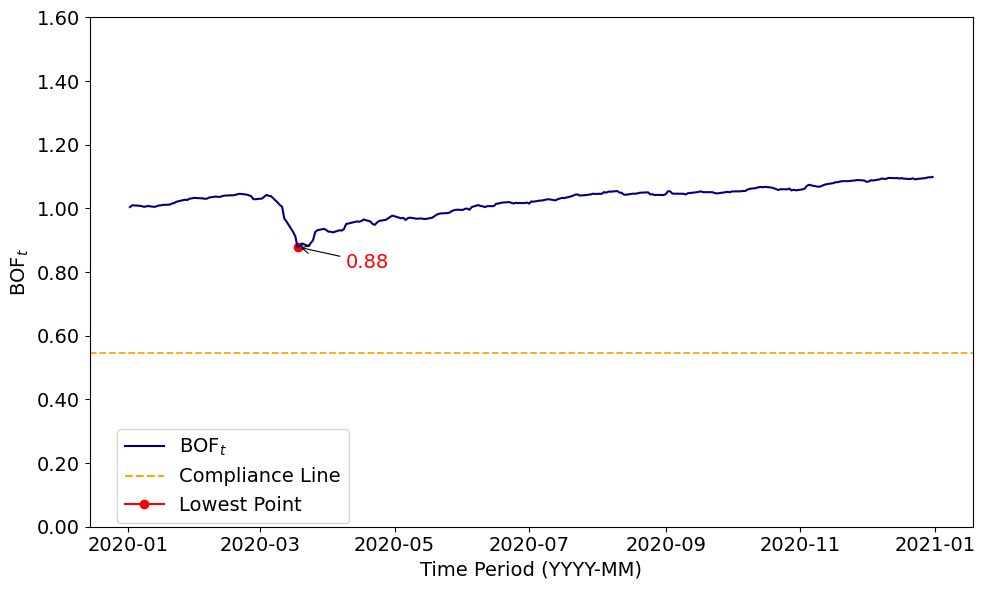

--------------NEW PARETO FRONT--------------
Compliance = 0.19700459612209464
SCR = 63041.47075907029
Configuration: VaR with Gaussian


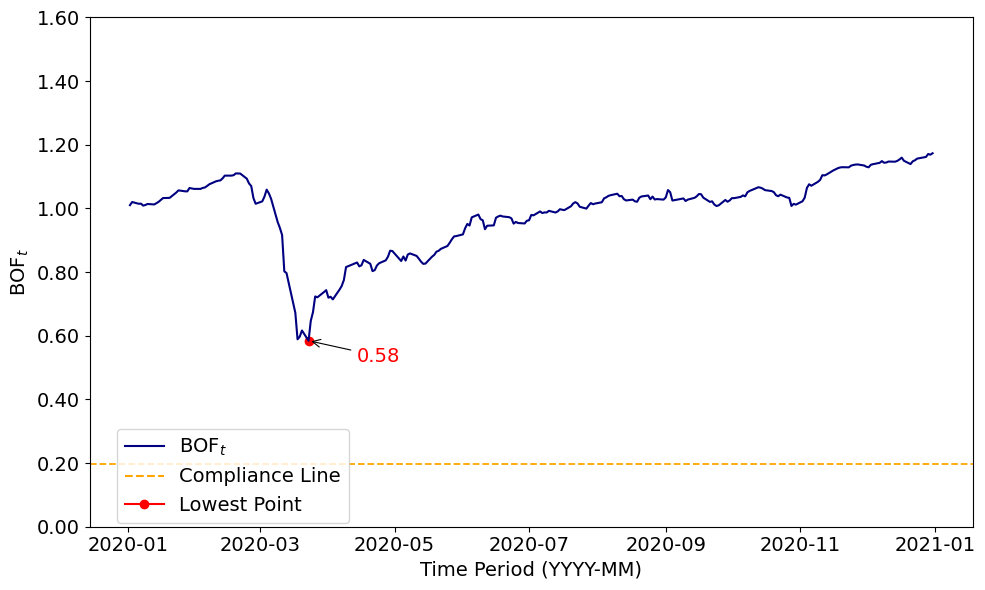

--------------NEW PARETO FRONT--------------
Compliance = 0.23222027834353298
SCR = 74310.48906993055
Configuration: CVaR with Gaussian


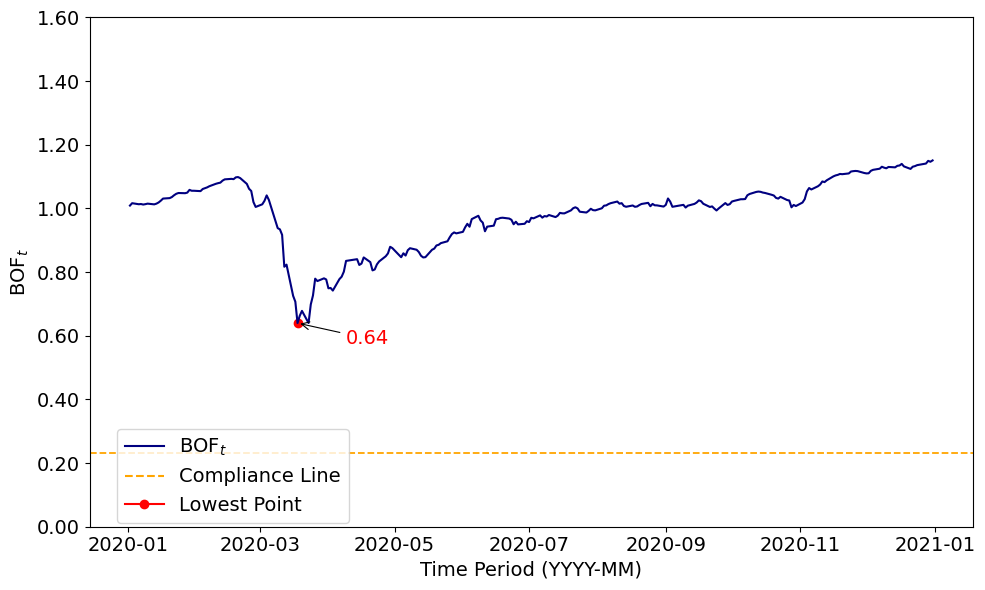

--------------NEW PARETO FRONT--------------
Compliance = 0.4674161371388348
SCR = 149573.16388442714
Configuration: VaR with t-Student


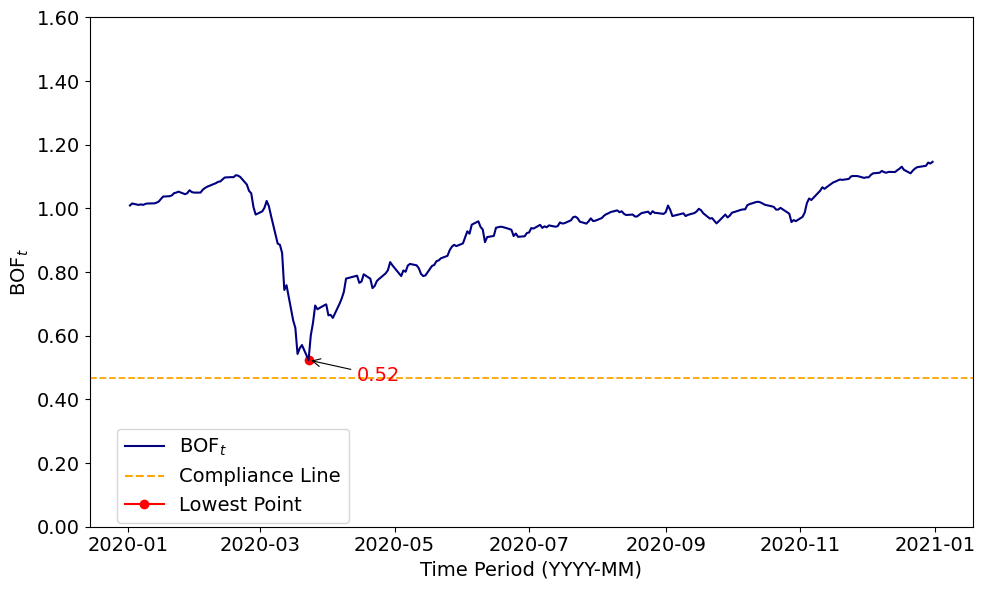

--------------NEW PARETO FRONT--------------
Compliance = 0.25817052136199625
SCR = 82614.56683583879
Configuration: CVaR with t-Student


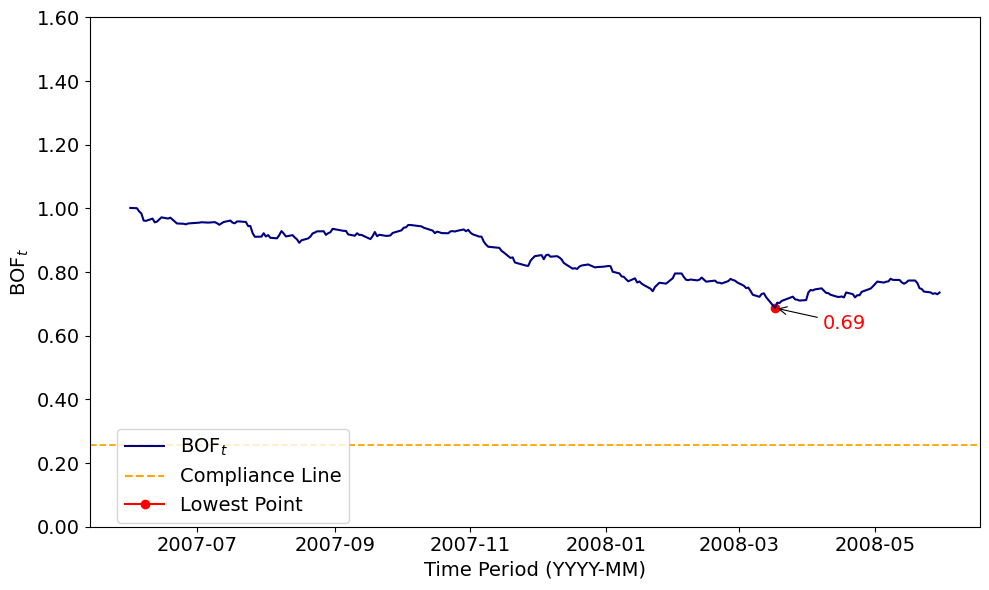

--------------NEW PARETO FRONT--------------
Compliance = 0.11240655417716837
SCR = 35970.09733669388
Configuration: VaR with Gaussian


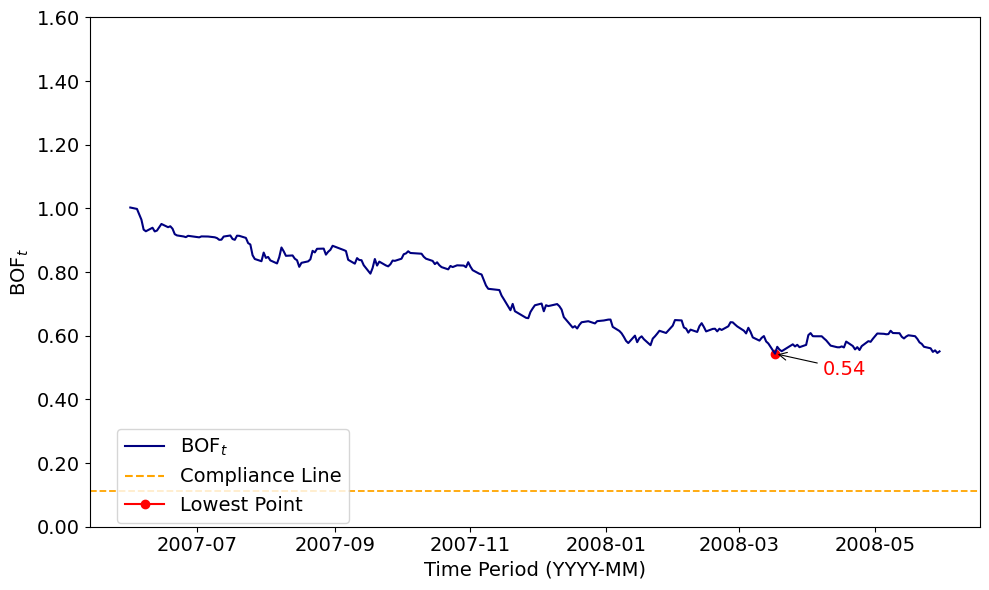

--------------NEW PARETO FRONT--------------
Compliance = 0.09158286660651313
SCR = 29306.5173140842
Configuration: CVaR with Gaussian


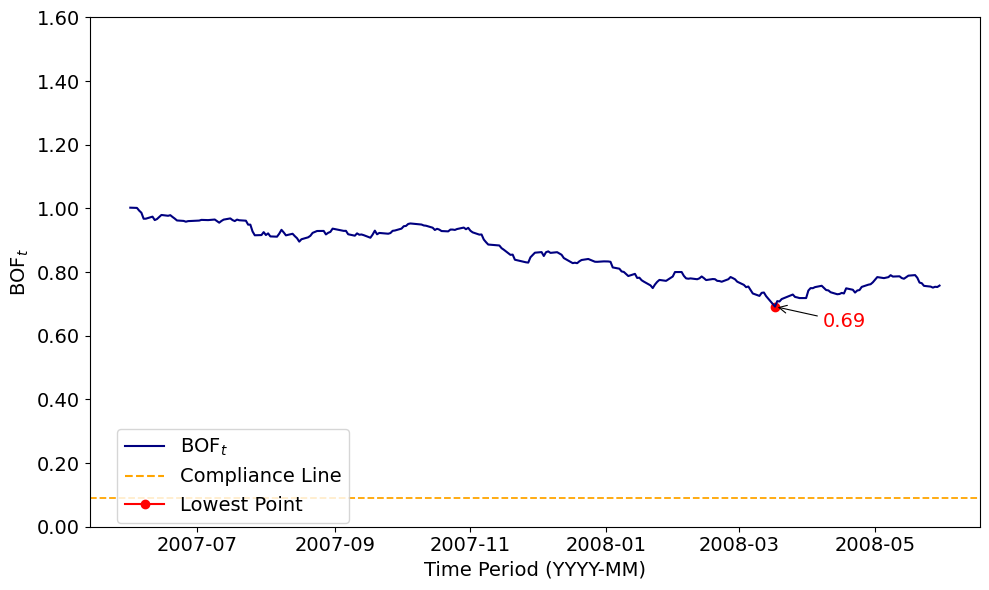

--------------NEW PARETO FRONT--------------
Compliance = 0.08856693153281017
SCR = 28341.418090499257
Configuration: VaR with t-Student


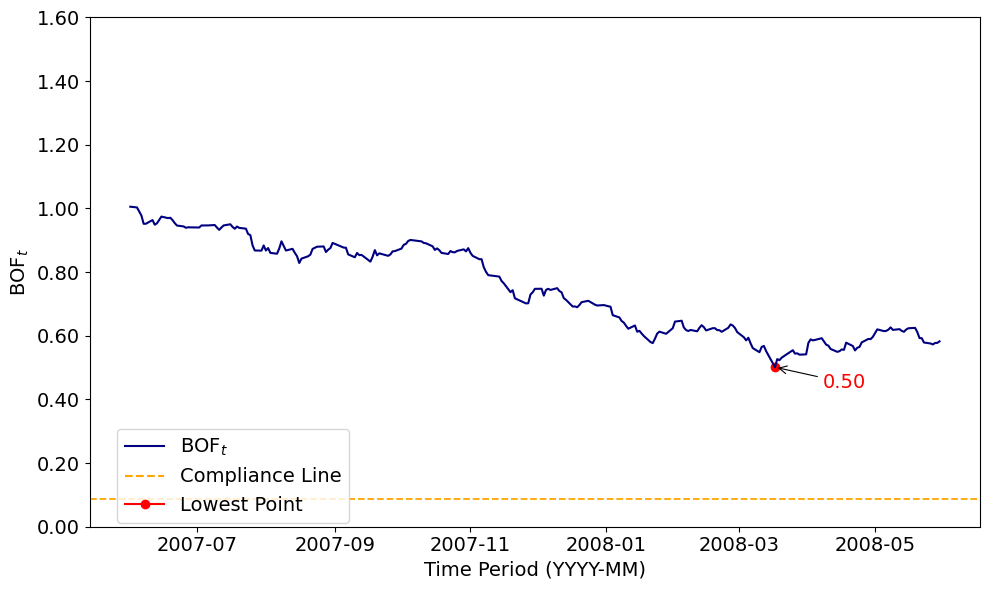

--------------NEW PARETO FRONT--------------
Compliance = 0.23545869836329417
SCR = 75346.78347625413
Configuration: VaR with Gaussian


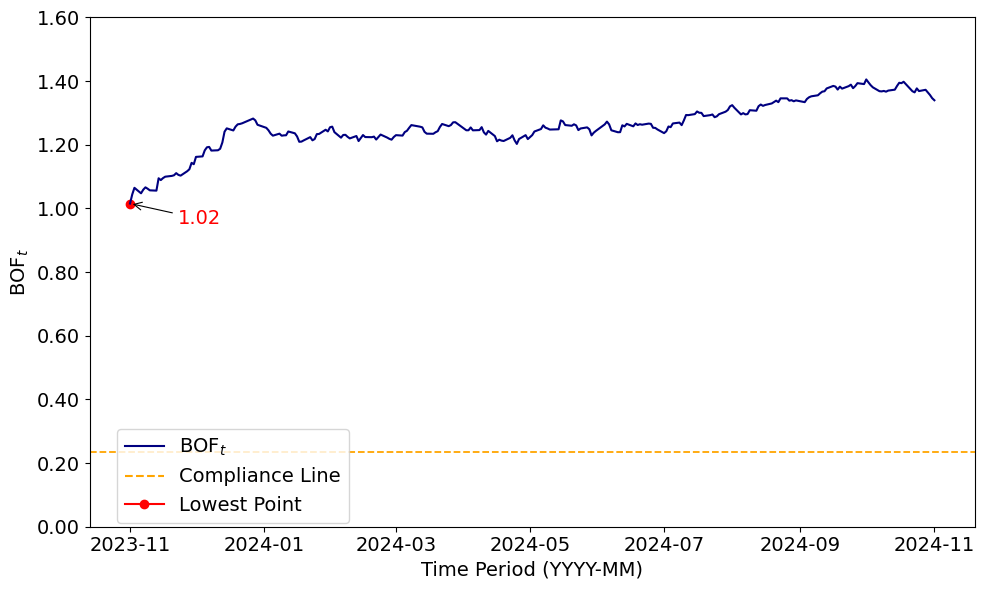

--------------NEW PARETO FRONT--------------
Compliance = 0.324825616997026
SCR = 103944.19743904832
Configuration: CVaR with Gaussian


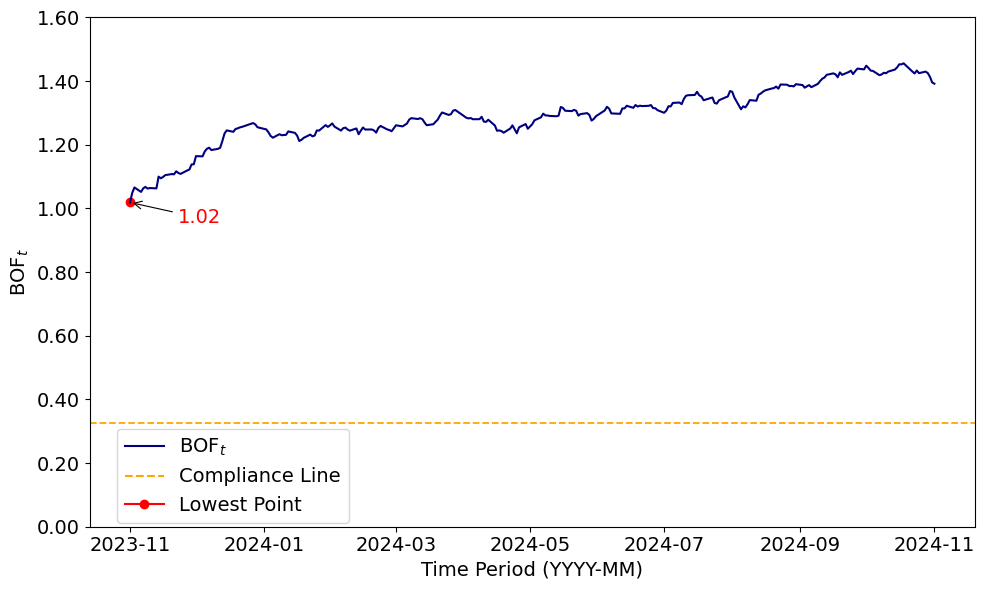

--------------NEW PARETO FRONT--------------
Compliance = 0.530526778262533
SCR = 169768.56904401057
Configuration: VaR with t-Student


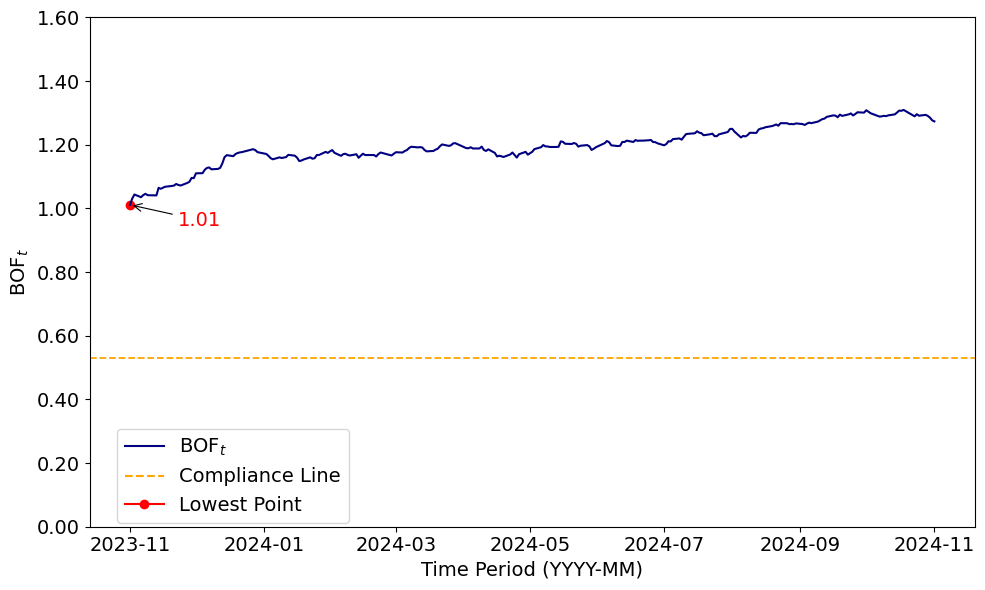

In [563]:
for pareto_front in pareto_fronts:
    print("--------------NEW PARETO FRONT--------------")
    i = 0
    for portfolio in pareto_front:
        i += 1
        bof_changes = []

        weights = portfolio["weights"]
        period = portfolio["period"]
        start_date = pd.to_datetime(
            period[0], format='%Y-%m-%d', errors='coerce')
        end_date = pd.to_datetime(
            period[1], format='%Y-%m-%d', errors='coerce')

        filtered_df = df[(df.index >= str(start_date))
                         & (df.index <= str(end_date))]

        assets_0 = 1000000
        liabilities_0 = assets_0 * frac_liabilities

        for current_date in filtered_df.index:
            current_data = filtered_df.loc[:current_date]

            stock_returns = current_data
            eonia_returns = current_data["EONIA"]
            portfolio_returns = np.dot(stock_returns.values, weights)
            cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1

            cumulative_liability_growth = np.prod(1 + eonia_returns) - 1

            bof_1 = ((1 + cumulative_portfolio_return) * assets_0) - \
                ((1+cumulative_liability_growth) * liabilities_0)


            bof_t = bof_1 / (assets_0 - liabilities_0)

            bof_changes.append({
                "time": current_date,
                "final_bof": bof_t,
                "risk_measure": portfolio["risk_measure"]
            })

        bof_changes_df = pd.DataFrame(bof_changes)

        plt.figure(figsize=(10, 6))
        plt.plot(
            bof_changes_df["time"],
            bof_changes_df["final_bof"],
            color="navy", linewidth=1.5, label=r"$\Delta$ BOF_t", 

        )

        min_bof_index = bof_changes_df["final_bof"].idxmin()
        min_bof_value = bof_changes_df.loc[min_bof_index, "final_bof"]
        min_bof_time = bof_changes_df.loc[min_bof_index, "time"]

        plt.scatter(min_bof_time, min_bof_value,
                    color="red", label="Lowest Point")
        plt.annotate(
            f"{min_bof_value:,.2f}",
            (min_bof_time, min_bof_value),
            textcoords="offset points",
            xytext=(50, -15),
            ha='center',
            fontsize=14,
            color="red",
            arrowprops=dict(facecolor='red', arrowstyle="->", lw=0.8)
        )

        compliance = portfolio['SCR_risk'] / (assets_0 - liabilities_0)
        print("Compliance =", compliance)
        plt.axhline(compliance, color="orange", linestyle="--", linewidth=1.3, alpha=1, label="Compliance Line")
        print(f"SCR = {portfolio['SCR_risk']}")

        plt.ylim(0, 1.6)
        plt.gca().yaxis.set_major_formatter(
            mticker.StrMethodFormatter('{x:,.2f}'))

        info_text = "\n".join([f"{key}: {value}" for key, value in portfolio.items(
        ) if key not in ["weights", "expected_return", "period"]])
        
        risk_measure_mapping = {
            "var": "VaR",
            "cvar": "CVaR"
        }

        distribution_mapping = {
            "normal": "Gaussian",
            "tstudent": "t-Student"
        }

        info = {
            "Risk Measure": risk_measure_mapping.get(portfolio["risk_measure"].lower(), portfolio["risk_measure"]),
            "Distribution": distribution_mapping.get(portfolio["distribution"].lower(), portfolio["distribution"])
        }

        info_legend_text = "\n".join(
            [f"{key}: {value}" for key, value in info.items()])

        plt.legend(
            handles=[
                plt.Line2D([], [], color='navy', label=r"$\text{BOF}_t$"),
                plt.Line2D([], [], color='orange', linestyle="--",
                           label="Compliance Line"),
                plt.Line2D([], [], color='red', marker='o',
                           label="Lowest Point")
            ],
            loc='center left', 
            bbox_to_anchor=(0.02, 0.1),
            frameon=True,
            fontsize=14,
            
        )

        title_text = f"Configuration: {info['Risk Measure']} with {info['Distribution']}"

        
        plt.xlabel("Time Period (YYYY-MM)", size=14)
        plt.ylabel(r"$\text{BOF}_t$", size=14)
        #plt.title(title_text, size=14)
        print(title_text)

        plt.tick_params(axis='x', labelsize=14)  # Adjust the font size for x-axis tick labels
        plt.tick_params(axis='y', labelsize=14) 
    
        plt.grid(False)
        plt.tight_layout()
        plt.show()